# All the Library imports

In [ ]:
import mimetypes
from pathlib import Path
import os
import sys
import random
import shutil
from tempfile import TemporaryDirectory
import cv2
import matplotlib.pyplot as plt
import json
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import torch as tc
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageOps
import torch.optim as optim
import albumentations as A
import torch.nn as nn
from tqdm.notebook import trange, tqdm
import imgaug.augmenters as ia

# Data Aquisition

### Clone the github repo to get all the data we have collected

In [ ]:
dataDir = TemporaryDirectory(dir='/content/sample_data', prefix='github_')
!git clone https://github.com/waruna-wickramasingha/landmark-detection.git $dataDir.name
# !git -C $dataDir.name/landmarks checkout feature/datarestructure

Cloning into '/content/sample_data/github_gp9rb5ex'...
remote: Enumerating objects: 1965, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 1965 (delta 14), reused 55 (delta 14), pack-reused 1907
Receiving objects: 100% (1965/1965), 1.95 GiB | 21.01 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Updating files: 100% (1682/1682), done.


In [ ]:
def getFilesList(path: str, desiredExtensionList, recursion=False):
  fileList = []
  path = Path(path)
  if recursion == False:
    for x in path.iterdir():
      if x.suffix.lower() in desiredExtensionList:
        fileList.append(x)
  else:
    for x in path.glob('**/*'):
      if x.suffix.lower() in desiredExtensionList:
        fileList.append(x)
  return fileList

In [ ]:
def getImageNameToClassMap(annotationsDir:str):
  aggrImageNameToClassMap = dict()
  aggrImageBoundingBoxMap = dict()
  annotationsDir = Path(annotationsDir)
  try:
    for x in annotationsDir.iterdir():
      if x.suffix.lower() == ".json":
        with open(x, 'r') as f:
          annotationDict = json.load(f)
          annList = list(map(dict, annotationDict.values()))
          image_name_to_class_map = { it['filename'] : it['regions'][0]['region_attributes']['class'].lower() for it in annList }
          image_name_to_boundingbox_map = { it['filename'] :[ it['regions'][0]['shape_attributes']['x'],it['regions'][0]['shape_attributes']['y'],
                                                             it['regions'][0]['shape_attributes']['width'],it['regions'][0]['shape_attributes']['height']] for it in annList }
          aggrImageNameToClassMap.update(image_name_to_class_map)
          aggrImageBoundingBoxMap.update(image_name_to_boundingbox_map )
  except:
    raise Exception("Failed to aggregate annotated json files")
  finally:
    print("Annotation files aggragated successfully!")
  return aggrImageNameToClassMap,aggrImageBoundingBoxMap

In [ ]:
im_name_to_class,im_annotations = getImageNameToClassMap(dataDir.name + '/annotations')
len(im_name_to_class)

Annotation files aggragated successfully!


1655

In [ ]:
dataDir.name+'/landmarks' 

'/content/sample_data/github_ques1cr8/landmarks'

In [ ]:
#Function to display an annotated image for n classes
def show_annotations(annotationsDir:str, num:int):
  fig_count=0;
  annotationsDir = Path(annotationsDir)
  
  for x in annotationsDir.iterdir():
    if(fig_count ==num):
      break
    for y in x.iterdir():
      print(os.path.basename(y))
      im = Image.open(y)
      im = ImageOps.exif_transpose(im)
      fig, ax = plt.subplots()
      ax.set_xlabel( im_name_to_class[os.path.basename(y)])
      ax.imshow(im)
      rect = mpatches.Rectangle((im_annotations[os.path.basename(y)][0], im_annotations[os.path.basename(y)][1]),
                                im_annotations[os.path.basename(y)][2], im_annotations[os.path.basename(y)][3], 
                                linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      plt.show()
      break;
    fig_count+=1



Aniba_1 of_2.jpg


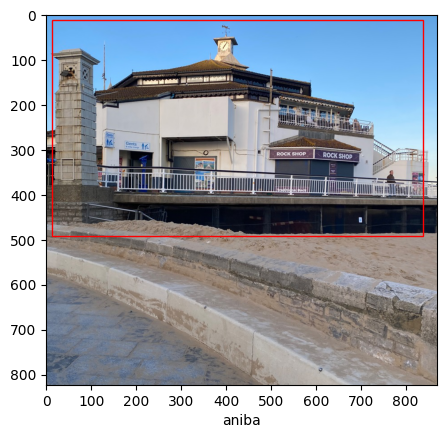

Nation-Wide_1 of_3.jpg


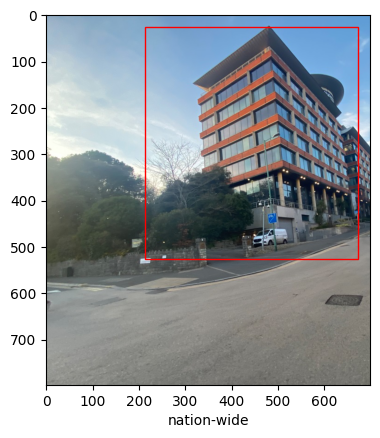

IMG_7539.JPG


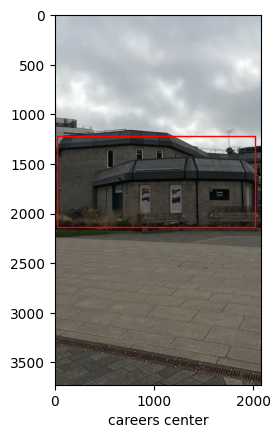

Ashley Automotive_6.JPG


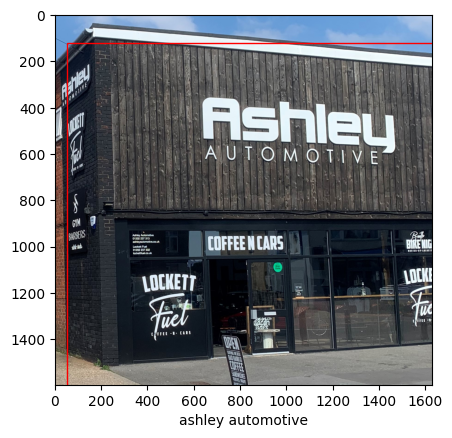

IMG_7354.JPG


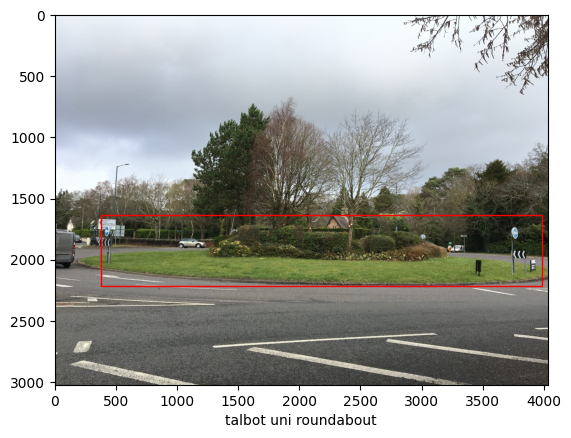

20230327_154445.jpg


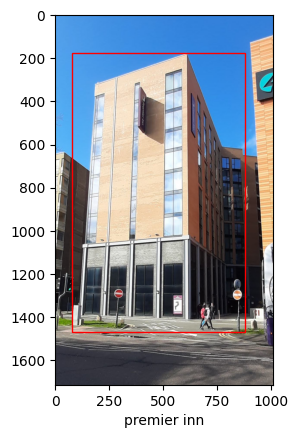

BUTA_1 of_4.jpg


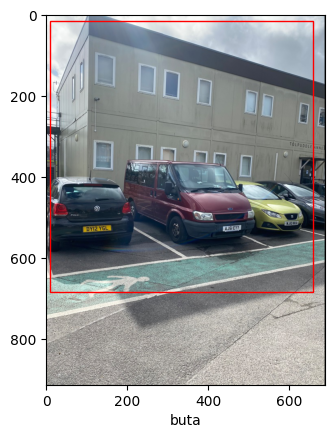

IMG_7887.JPG


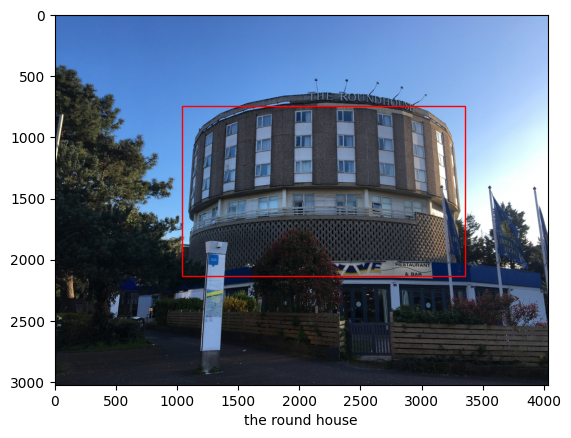

Richmond-Gate_1 of_8.jpg


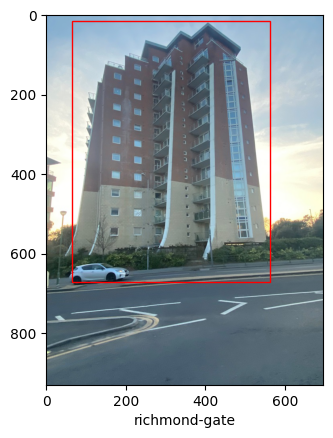

IMG_7424.JPG


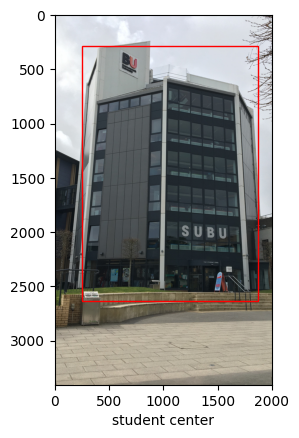

In [ ]:
x1=show_annotations(dataDir.name + '/landmarks', 10)
x1

In [ ]:
im_name_to_class

{'20230326_155150.jpg': 'bailey point',
 '20230326_155152.jpg': 'bailey point',
 '20230326_155206.jpg': 'bailey point',
 '20230326_155213.jpg': 'bailey point',
 '20230326_155227.jpg': 'bailey point',
 '20230326_155253.jpg': 'bailey point',
 '20230326_155301.jpg': 'bailey point',
 '20230402_182532.jpg': 'bailey point',
 '20230402_182534.jpg': 'bailey point',
 '20230402_182601.jpg': 'bailey point',
 '20230402_182602.jpg': 'bailey point',
 '20230402_182608.jpg': 'bailey point',
 '20230326_160658.jpg': 'bu executive business centre',
 '20230326_160704.jpg': 'bu executive business centre',
 '20230326_160803.jpg': 'bu executive business centre',
 '20230326_160814.jpg': 'bu executive business centre',
 '20230326_160817.jpg': 'bu executive business centre',
 '20230326_160821.jpg': 'bu executive business centre',
 '20230326_160922.jpg': 'bu executive business centre',
 '20230326_160923.jpg': 'bu executive business centre',
 '20230326_160933.jpg': 'bu executive business centre',
 '20230326_16094

In [ ]:
all_classes = set(im_name_to_class.values())
all_classes

{'aldi wallisdown',
 'aniba',
 'art studios',
 'arts bar',
 'arts bu library',
 'asda',
 'ashley automotive',
 'auds',
 'aush',
 'auss',
 'autg',
 'baboo ji',
 'bailey point',
 'beales',
 'bellaton house',
 'block a and block b arts university',
 'bobbys',
 'bournemouth and poole college',
 'bournemouth gateway building',
 'bu executive business centre',
 'bu international college',
 'bu lansdowne',
 'bu student house',
 'buch',
 'burley court hotel',
 'buta',
 'buth',
 'careers center',
 'cbd flower shop',
 'church',
 'coop store',
 'court royal',
 'courtleigh manor',
 'cranborne house',
 'design and engineering innovation center',
 'dorchester house',
 'dorset house',
 'east cliff urc church',
 'enterprise house',
 'fairways care home',
 'fern arrow roundabout',
 'fusion building',
 'gorscliff court',
 'hilton',
 'home park',
 'hot rocks',
 'iq building',
 'jakey house',
 'kimmeridge house',
 'lester aldridge',
 'lidl bournemouth',
 'lush',
 'mccarthy stone head office',
 'minton lod

In [ ]:
len(all_classes)

100

In [ ]:
for k,v in im_name_to_class.items():
  if v == '':
    print(k)

In [ ]:
beforeAugImagesRoot = TemporaryDirectory(dir='/content/sample_data', prefix='BeforeAugmentation_')
testImagesRoot = TemporaryDirectory(dir='/content/sample_data', prefix='Test_')

## Re-arrange data into train and test sets using 75% trainig split 

In [ ]:
image_extensions = [k for k,v in mimetypes.types_map.items() if 'image/' in v]
random.seed(13)

def reArrangeImagesIntoTrainTest(lm_dir:str, trainDir:str, testDir:str, trainSplit=0.75):
  """
  This method would split the original list of images provided in imagesList 
  by moving them into trainDir and testDir keeping the original file name.
  """
  global image_extensions
  imagesList = getFilesList(lm_dir, image_extensions)
  imagesList = np.array(imagesList)
  randSelections = np.random.permutation(len(imagesList))

  trainTestCutPoint = int(len(imagesList)*trainSplit)
  trainImages = imagesList[randSelections[:trainTestCutPoint]]
  testImages = imagesList[randSelections[trainTestCutPoint:]]

  lm_dir_name = lm_dir.split(os.sep)[-1]

  try:
    #Re-arrange train images
    lm_train_dir = TemporaryDirectory(dir=trainDir, prefix=lm_dir_name)
    print("Creating Train directory={}".format(lm_train_dir.name))
    for p in trainImages:
      imageName = str(p).split(os.sep)[-1]
      newPath = lm_train_dir.name + os.sep + imageName
      shutil.move(p, newPath)

    #Re-arrange test images
    lm_test_dir = TemporaryDirectory(dir=testDir, prefix=lm_dir_name)
    print("Creating Test directory={}".format(lm_test_dir.name))
    for p in testImages:
      imageName = str(p).split(os.sep)[-1]
      newPath = lm_test_dir.name + os.sep + imageName
      shutil.move(p, newPath)
  except:
    raise Exception("Failed to move images into train={} and test={} directories".
                    format(lm_train_dir.name, lm_test_dir.name))
  return (lm_train_dir, lm_test_dir)

In [ ]:
landmarks_dir = Path(dataDir.name+os.sep+'landmarks')
tempdirs = []
for lm in landmarks_dir.glob('**/'):
  if lm == landmarks_dir:
    continue
  print("\n Original direcotry={}".format(lm))
  tempdirs.append(reArrangeImagesIntoTrainTest(str(lm), beforeAugImagesRoot.name, testImagesRoot.name, 0.75))


 Original direcotry=/content/sample_data/github_ques1cr8/landmarks/Aniba
Creating Train directory=/content/sample_data/BeforeAugmentation_wp_aex05/Anibagnupd0pb
Creating Test directory=/content/sample_data/Test_v6mf3z3f/Aniba094_m9sd

 Original direcotry=/content/sample_data/github_ques1cr8/landmarks/Nation-Wide
Creating Train directory=/content/sample_data/BeforeAugmentation_wp_aex05/Nation-Wides4qoqbvd
Creating Test directory=/content/sample_data/Test_v6mf3z3f/Nation-Widezmam_d2h

 Original direcotry=/content/sample_data/github_ques1cr8/landmarks/careers center
Creating Train directory=/content/sample_data/BeforeAugmentation_wp_aex05/careers center1xxunz1m
Creating Test directory=/content/sample_data/Test_v6mf3z3f/careers centeripa0m0w0

 Original direcotry=/content/sample_data/github_ques1cr8/landmarks/Ashley Automotive
Creating Train directory=/content/sample_data/BeforeAugmentation_wp_aex05/Ashley Automotivex_os_x46
Creating Test directory=/content/sample_data/Test_v6mf3z3f/Ashle

In [ ]:
image_extensions

['.bmp',
 '.gif',
 '.ief',
 '.jpg',
 '.jpe',
 '.jpeg',
 '.heic',
 '.heif',
 '.png',
 '.svg',
 '.tiff',
 '.tif',
 '.ico',
 '.ras',
 '.pnm',
 '.pbm',
 '.pgm',
 '.ppm',
 '.rgb',
 '.xbm',
 '.xpm',
 '.xwd']

In [ ]:
getFilesList(beforeAugImagesRoot.name, image_extensions, recursion=True)

[PosixPath('/content/sample_data/BeforeAugmentation_wp_aex05/dorset housekv_d9swy/IMG_7486.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_wp_aex05/dorset housekv_d9swy/IMG_7479.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_wp_aex05/dorset housekv_d9swy/IMG_7487.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_wp_aex05/dorset housekv_d9swy/IMG_7496.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_wp_aex05/dorset housekv_d9swy/IMG_7482.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_wp_aex05/dorset housekv_d9swy/20230330_174647.jpg'),
 PosixPath('/content/sample_data/BeforeAugmentation_wp_aex05/dorset housekv_d9swy/IMG_7478.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_wp_aex05/dorset housekv_d9swy/IMG_7476.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_wp_aex05/dorset housekv_d9swy/20230330_174556.jpg'),
 PosixPath('/content/sample_data/BeforeAugmentation_wp_aex05/dorset housekv_d9swy/IMG_7497.JPG'),
 Posix

In [ ]:
getFilesList(testImagesRoot.name, image_extensions, recursion=True)

[PosixPath('/content/sample_data/Test_v6mf3z3f/waymouth housechd_n3yc/IMG_7597.JPG'),
 PosixPath('/content/sample_data/Test_v6mf3z3f/waymouth housechd_n3yc/IMG_7615.JPG'),
 PosixPath('/content/sample_data/Test_v6mf3z3f/waymouth housechd_n3yc/IMG_7636.JPG'),
 PosixPath('/content/sample_data/Test_v6mf3z3f/waymouth housechd_n3yc/IMG_7613.JPG'),
 PosixPath('/content/sample_data/Test_v6mf3z3f/waymouth housechd_n3yc/IMG_7639.JPG'),
 PosixPath('/content/sample_data/Test_v6mf3z3f/waymouth housechd_n3yc/IMG_7635.JPG'),
 PosixPath('/content/sample_data/Test_v6mf3z3f/waymouth housechd_n3yc/IMG_7614.JPG'),
 PosixPath('/content/sample_data/Test_v6mf3z3f/waymouth housechd_n3yc/IMG_7610.JPG'),
 PosixPath('/content/sample_data/Test_v6mf3z3f/waymouth housechd_n3yc/IMG_7640.JPG'),
 PosixPath('/content/sample_data/Test_v6mf3z3f/waymouth housechd_n3yc/IMG_7628.JPG'),
 PosixPath('/content/sample_data/Test_v6mf3z3f/Bealeser48p_wk/Beales_1 of_10.jpg'),
 PosixPath('/content/sample_data/Test_v6mf3z3f/Bealeser4

## Define class to integer and integer to class conversion data structures to map string class names to numbers and vice-versa

In [ ]:
all_classes

{'aldi wallisdown',
 'aniba',
 'art studios',
 'arts bar',
 'arts bu library',
 'asda',
 'ashley automotive',
 'auds',
 'aush',
 'auss',
 'autg',
 'baboo ji',
 'bailey point',
 'beales',
 'bellaton house',
 'block a and block b arts university',
 'bobbys',
 'bournemouth and poole college',
 'bournemouth gateway building',
 'bu executive business centre',
 'bu international college',
 'bu lansdowne',
 'bu student house',
 'buch',
 'burley court hotel',
 'buta',
 'buth',
 'careers center',
 'cbd flower shop',
 'church',
 'coop store',
 'court royal',
 'courtleigh manor',
 'cranborne house',
 'design and engineering innovation center',
 'dorchester house',
 'dorset house',
 'east cliff urc church',
 'enterprise house',
 'fairways care home',
 'fern arrow roundabout',
 'fusion building',
 'gorscliff court',
 'hilton',
 'home park',
 'hot rocks',
 'iq building',
 'jakey house',
 'kimmeridge house',
 'lester aldridge',
 'lidl bournemouth',
 'lush',
 'mccarthy stone head office',
 'minton lod

In [ ]:
i2c = list(all_classes)
c2i = {v:i for i,v in enumerate(i2c)}

In [ ]:
i2c

['talbot bus stop',
 'slug',
 'burley court hotel',
 'pets corner',
 'wiggle',
 'fern arrow roundabout',
 'royal london house',
 'home park',
 'sports bu',
 'beales',
 'tesco',
 'the gallery arts university',
 'jakey house',
 'enterprise house',
 'lidl bournemouth',
 'buth',
 'student center',
 'cbd flower shop',
 'talbot uni roundabout',
 'block a and block b arts university',
 'arts bar',
 'bellaton house',
 'the round house',
 'bu international college',
 'buch',
 'church',
 'autg',
 'tolpuddle annex 2',
 'skyline accomodation',
 'iq building',
 'timebomb tattoo studio',
 'arts bu library',
 'aniba',
 'hilton',
 'obscura',
 'courtleigh manor',
 'kimmeridge house',
 'odeon',
 'nation-wide',
 'sprinkles gelato',
 'time bomb tattoo studio',
 'design and engineering innovation center',
 'cranborne house',
 'careers center',
 'lester aldridge',
 'naked coffee',
 'bu executive business centre',
 'baboo ji',
 'oceanorium',
 'east cliff urc church',
 'poole house cafe',
 'oneils bournemouth

In [ ]:
c2i

{'talbot bus stop': 0,
 'slug': 1,
 'burley court hotel': 2,
 'pets corner': 3,
 'wiggle': 4,
 'fern arrow roundabout': 5,
 'royal london house': 6,
 'home park': 7,
 'sports bu': 8,
 'beales': 9,
 'tesco': 10,
 'the gallery arts university': 11,
 'jakey house': 12,
 'enterprise house': 13,
 'lidl bournemouth': 14,
 'buth': 15,
 'student center': 16,
 'cbd flower shop': 17,
 'talbot uni roundabout': 18,
 'block a and block b arts university': 19,
 'arts bar': 20,
 'bellaton house': 21,
 'the round house': 22,
 'bu international college': 23,
 'buch': 24,
 'church': 25,
 'autg': 26,
 'tolpuddle annex 2': 27,
 'skyline accomodation': 28,
 'iq building': 29,
 'timebomb tattoo studio': 30,
 'arts bu library': 31,
 'aniba': 32,
 'hilton': 33,
 'obscura': 34,
 'courtleigh manor': 35,
 'kimmeridge house': 36,
 'odeon': 37,
 'nation-wide': 38,
 'sprinkles gelato': 39,
 'time bomb tattoo studio': 40,
 'design and engineering innovation center': 41,
 'cranborne house': 42,
 'careers center': 43,

Let's check whether we can find a class for all the images in the data set with the original images before augmentation.

In [ ]:
for f in getFilesList(beforeAugImagesRoot.name, image_extensions, recursion=True):
  image_filepath = str(f)
  orig_im_name = str(image_filepath).split(os.sep)[-1]
  cls = im_name_to_class[orig_im_name]
  label = c2i[cls]

Check whether all the images in the test data set has a class associated

In [ ]:
for f in getFilesList(testImagesRoot.name, image_extensions, recursion=True):
  image_filepath = str(f)
  im_name = str(image_filepath).split(os.sep)[-1]
  orig_im_name = im_name
  cls = im_name_to_class[orig_im_name]
  label = c2i[cls]

# Data Augmentation

In [ ]:
def doAugmentation(inputDir: str, outputDirRoot: str, augmentationPipeline, numberOfTargetSamples):
  """
  This function is to perform image augmentations for the images present at the 'inputDir' 
  into the root location as specified at 'outputDirRoot' using the function 'augmentationPipeline' 
  which takes in an image and output an augmented image. The new directory will be created with the same prefix
  as the input directory and it will contain all the original images plus a number of augmented images 
  such that 'numberOfTargetSamples' is reached
  """
  inputDirPath = Path(inputDir)
  originalImagePaths = []

  global image_extensions
  for x in inputDirPath.iterdir():
      if x.suffix.lower() in image_extensions:
          originalImagePaths.append(x)

  origLMDir = inputDir.split(os.sep)[-1]

  try:
      augLMDir = TemporaryDirectory(dir=outputDirRoot, prefix="{}_Aug_".format(origLMDir))
  except:
      raise Exception("Error creating temp dir for augmentations")

  print("Original Directory={}, Augmented Directory={}".format(inputDir, augLMDir.name))

  for im in originalImagePaths:
      imageName = str(im).split(os.sep)[-1]
      outputImagePath = augLMDir.name + os.sep + imageName
      
      try:
          shutil.copy(im, outputImagePath)
      except:
          raise Exception("Failed to copy original file {} to {}".format(im, outputImagePath))

  augCandidates = random.choices(originalImagePaths, k=(numberOfTargetSamples-len(originalImagePaths)))
  aug_ind = 0

  for impath in augCandidates:
      im = cv2.imread(str(impath))
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

      augmentedImage = augmentationPipeline(im)
      imageName, imageExt = str(impath).split(os.sep)[-1].split('.')
      outputImagePath = augLMDir.name + os.sep + 'aug#' + str(aug_ind) + '_' + imageName + '.' + imageExt
      aug_ind += 1
      try:
          cv2.imwrite(outputImagePath, augmentedImage)
      except:
          raise Exception("Failed to save augmented image to {}".format(outputImagePath))
      
  return augLMDir

### Define pipelines for data augmentation

In [ ]:
transform = A.Compose(
        [A.RandomRotate90(),
        A.RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.4, p=0.7),
        # A.CLAHE(p=0.7),
        A.HorizontalFlip(p=0.7),
        # A.Transpose(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75),
        A.Blur(blur_limit=3)])

def augmentationPipelineWaruna(image):
  return transform(image=image)['image']

In [ ]:
#Augmentation pipeline using imgaug Library

seq = ia.Sequential(
    [
        ia.Fliplr(0.5),  
        ia.Crop(percent=(0, 0.05)),            
        ia.Sometimes(0.5, ia.GaussianBlur(sigma=(0, 0.5))),        
        ia.ContrastNormalization((0.75, 1.5)),         
        ia.AdditiveGaussianNoise(
            loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),    
        ia.Sometimes(0.10,ia.MotionBlur(k=5,angle=[-45, 45])),
        ia.LinearContrast((0.4, 0.8), per_channel=True),
        ia.pillike.EnhanceContrast(), 
        ia.pillike.EnhanceBrightness(),  
        ia.Sometimes(0.25,ia.Rot90(keep_size=False)),
    ],
    random_order=True)  # apply augmenters in random order
def augmentationPipelineForVishal(image):
  return seq(image=image)

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [ ]:
augmentationDirRoot = TemporaryDirectory(dir='/content/sample_data', prefix='Augmentations')
augmentationDirRoot.name

'/content/sample_data/Augmentations80jnivzf'

In [ ]:
%%time

# todo ....

original_dir_before_aug = Path(beforeAugImagesRoot.name)
augmented_dirs = []
augmentation_ind = 0
for lm in original_dir_before_aug.glob('**/'):
  if lm == original_dir_before_aug:
    continue
  augmentation_ind += 1

  if augmentation_ind <25:
    #Waruna
     augmented_dirs.append(doAugmentation(str(lm), augmentationDirRoot.name, augmentationPipelineWaruna, 50))
  elif augmentation_ind>= 25:
    #vishal
    augmented_dirs.append(doAugmentation(str(lm), augmentationDirRoot.name, augmentationPipelineForVishal, 50))
  #elif augmentation_ind> 51 and augmentation_ind < 75:
    #waruna
    # augmented_dirs.append(doAugmentation(str(lm), augmentationDirRoot.name, waruna_augmentationPipeline, 50))
  #else:
    #ayo
    # augmented_dirs.append(doAugmentation(str(lm), augmentationDirRoot.name, ayo_augmentationPipeline, 50))


Original Directory=/content/sample_data/BeforeAugmentation_wp_aex05/dorset housekv_d9swy, Augmented Directory=/content/sample_data/Augmentations80jnivzf/dorset housekv_d9swy_Aug_3pbm8is9
Original Directory=/content/sample_data/BeforeAugmentation_wp_aex05/Anibagnupd0pb, Augmented Directory=/content/sample_data/Augmentations80jnivzf/Anibagnupd0pb_Aug_jw26hr8g
Original Directory=/content/sample_data/BeforeAugmentation_wp_aex05/Block A and Block B Arts University3s99d6u0, Augmented Directory=/content/sample_data/Augmentations80jnivzf/Block A and Block B Arts University3s99d6u0_Aug_g1v_kqf3
Original Directory=/content/sample_data/BeforeAugmentation_wp_aex05/CBD Flower Shopgu9rswbm, Augmented Directory=/content/sample_data/Augmentations80jnivzf/CBD Flower Shopgu9rswbm_Aug_i3lw5qnh
Original Directory=/content/sample_data/BeforeAugmentation_wp_aex05/Skyline Accomodation35twoyzg, Augmented Directory=/content/sample_data/Augmentations80jnivzf/Skyline Accomodation35twoyzg_Aug_t61kfz0d
Original Di

In [ ]:

#Function to display some augmented images for n number of random classes in the dataset.
def displayAugmentedImages(augmentationDir:str, num:int):

  augmentationDir = Path(augmentationDir)
  label_count=num
  
  try:
    for x in augmentationDir.iterdir():
      if(label_count==0):
        break;
      label_count-=1
      for y in x.iterdir():
          aug_arr=[]
          if('aug' not in y.name):
            for z in x.iterdir():
              if(str(y.name) in z.name and 'aug' in z.name):
                aug_arr.append(z)  
            temp = Image.open(y)
            temp = ImageOps.exif_transpose(temp)
            plt.subplot(1,min(5,len(aug_arr)+1),1) # nx5 subplot to display the images
            plt.imshow(temp)   #first image in each row of subplot is the original image
            plt.title(im_name_to_class[y.name]) # add class label as the title

            for i in range(min(4,len(aug_arr))): #display augmented images in the same row 
              plt.axis('off')
              temp = Image.open(aug_arr[i])
              temp = ImageOps.exif_transpose(temp)
              plt.subplot(1,min(5,len(aug_arr)+1),i+2) 
              plt.imshow(temp)
           
            #ax.set_xlabel(os.path.basename(y))
            plt.axis('off')
            plt.show()
            break;
      
  except:
    raise Exception("Failed to display results")
  finally:
    print("Successfully displayed the augmented images")

In [ ]:
augmentationDirRoot.name

'/content/sample_data/Augmentations80jnivzf'

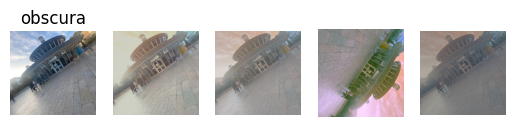

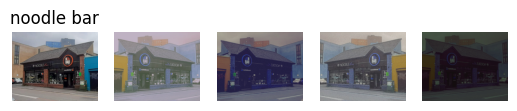

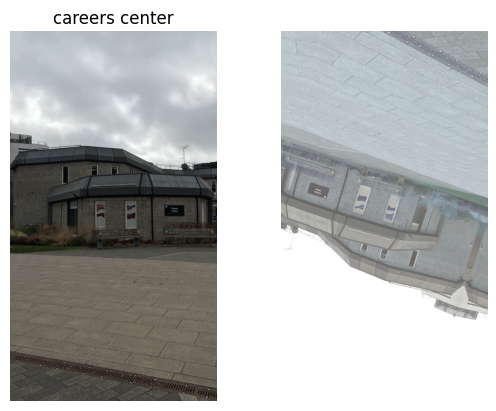

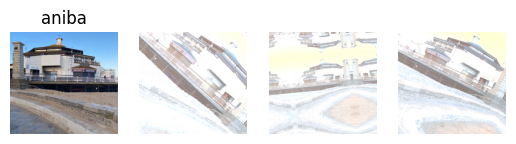

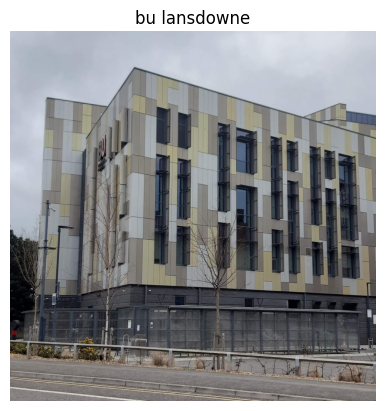

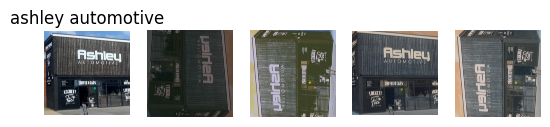

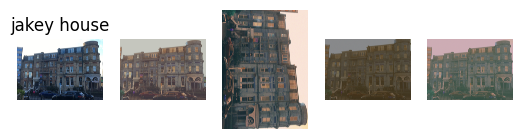

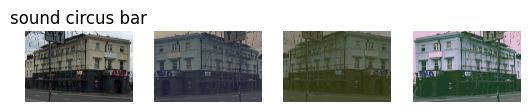

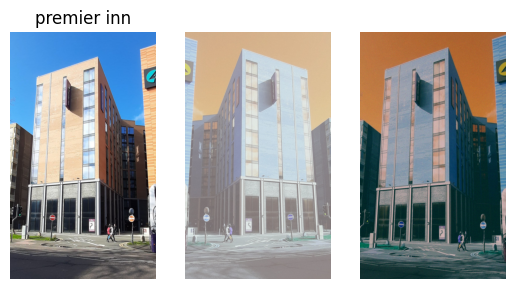

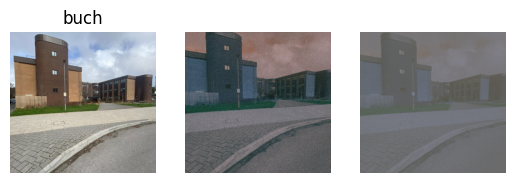

Successfully displayed the augmented images


In [ ]:
displayAugmentedImages(augmentationDirRoot.name,10) 

#Note: Rows with only one image signifies that particular image was not chosen for augmentation for that class

In [ ]:
augmentationDirRoot.name

# Define pytorch Data Sets and Data Loaders

In [ ]:
class LandmarkDataSet(Dataset):
  def __init__(self, imPathList, im2cl, c2i, transform):
    self.x = imPathList
    self.im2cl = im2cl
    self.c2i = c2i
    self.transform = transform

  def __len__(self): 
    return len(self.x)
    
  def __getitem__(self, ix): 
    image_filepath = str(self.x[ix])
    image = Image.open(image_filepath)
    
    im_name = str(image_filepath).split(os.sep)[-1]
    if 'aug#' in image_filepath:
      orig_im_name = im_name[im_name.find('_')+1:]
    else:
      orig_im_name = im_name

    cls = self.im2cl[orig_im_name]
    label = self.c2i[cls]
    if self.transform is not None:
      image = self.transform(image)
    
    return image, label

In [ ]:
train_image_paths_list = getFilesList(augmentationDirRoot.name, image_extensions, recursion=True)
test_image_paths_list = getFilesList(testImagesRoot.name, image_extensions, recursion=True)

In [ ]:
im_name_to_class

{'20230326_155150.jpg': 'bailey point',
 '20230326_155152.jpg': 'bailey point',
 '20230326_155206.jpg': 'bailey point',
 '20230326_155213.jpg': 'bailey point',
 '20230326_155227.jpg': 'bailey point',
 '20230326_155253.jpg': 'bailey point',
 '20230326_155301.jpg': 'bailey point',
 '20230402_182532.jpg': 'bailey point',
 '20230402_182534.jpg': 'bailey point',
 '20230402_182601.jpg': 'bailey point',
 '20230402_182602.jpg': 'bailey point',
 '20230402_182608.jpg': 'bailey point',
 '20230326_160658.jpg': 'bu executive business centre',
 '20230326_160704.jpg': 'bu executive business centre',
 '20230326_160803.jpg': 'bu executive business centre',
 '20230326_160814.jpg': 'bu executive business centre',
 '20230326_160817.jpg': 'bu executive business centre',
 '20230326_160821.jpg': 'bu executive business centre',
 '20230326_160922.jpg': 'bu executive business centre',
 '20230326_160923.jpg': 'bu executive business centre',
 '20230326_160933.jpg': 'bu executive business centre',
 '20230326_16094

### Data Normalization 

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)
    ])

train_ds  = LandmarkDataSet(train_image_paths_list, im_name_to_class, c2i, transf)
test_ds  = LandmarkDataSet(test_image_paths_list, im_name_to_class, c2i, transf)

len(train_ds), len(test_ds)

(5000, 448)

### Utility functions to fit the models and transfer-learn

In [ ]:
accuracy = lambda y_,yb: (y_.max(dim=1)[1] == yb).float().mean() 

def one_epoch(net, loss, dl, opt=None, metric=None):   
  if opt: net.train()  # only affects some layers
  else:   net.eval()

  L, M = [], []
  for xb, yb in tqdm(iter(dl), leave=False):
    xb, yb = xb.cuda(), yb.cuda()
    if opt:
      y_ = net(xb)
      l = loss(y_, yb)
      opt.zero_grad()
      l.backward()
      opt.step()
    else:
      with tc.no_grad():
        y_ = net(xb)
        l = loss(y_, yb)
    L.append(l.detach().cpu().numpy())
    if metric: 
      M.append(metric(y_, yb).cpu().numpy())
          
  return L, M


def fit(net, tr_dl, val_dl, loss=nn.CrossEntropyLoss(), epochs=10, lr=3e-3, wd=1e-3, plot=True):
  opt = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
  Ltr_hist, Lval_hist = [], []
  for epoch in trange(epochs):
    Ltr,  _    = one_epoch(net, loss, tr_dl,  opt)
    Lval, Aval = one_epoch(net, loss, val_dl, None, accuracy)
    Ltr_hist.append(np.mean(Ltr))
    Lval_hist.append(np.mean(Lval))
    print(f'epoch: {epoch}\ttraining loss: {np.mean(Ltr):0.4f}\tvalidation loss: {np.mean(Lval):0.4f}\tvalidation accuracy: {np.mean(Aval):0.2f}')
      
  # plot the losses     
  if plot:
    _,ax = plt.subplots(1,1,figsize=(16,4))
    ax.plot(1+np.arange(len(Ltr_hist)),Ltr_hist)
    ax.plot(1+np.arange(len(Lval_hist)),Lval_hist)
    ax.grid('on')
    ax.set_xlim(left=1, right=len(Ltr_hist))
    ax.legend(['training loss', 'validation loss']);
      
  return Ltr_hist, Lval_hist

def freeze(md, fr=True):
  ch = list(md.children())
  for c in ch: freeze(c, fr)
  if not ch and not isinstance(md, tc.nn.modules.batchnorm.BatchNorm2d):  # not freezing the BatchNorm layers!
    for p in md.parameters():
      p.requires_grad = not fr

def freeze_to(md, ix=-1, fr=True):
  ch_all = list(md.children())
  for ch in ch_all[:ix]:
    freeze(ch, fr)

In [ ]:
from torchvision.models import list_models

In [ ]:
list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [ ]:
temp = models.resnet18(pretrained=True)
temp

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
temp.fc

Linear(in_features=512, out_features=1000, bias=True)

# Transfer-learning Resnet18

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 248MB/s]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 0	training loss: 2.4330	validation loss: 0.6103	validation accuracy: 0.85


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 1	training loss: 0.6721	validation loss: 0.3253	validation accuracy: 0.94


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 2	training loss: 0.4707	validation loss: 0.2931	validation accuracy: 0.94


([2.432987, 0.6721023, 0.47072393], [0.61025345, 0.3252588, 0.29305324])

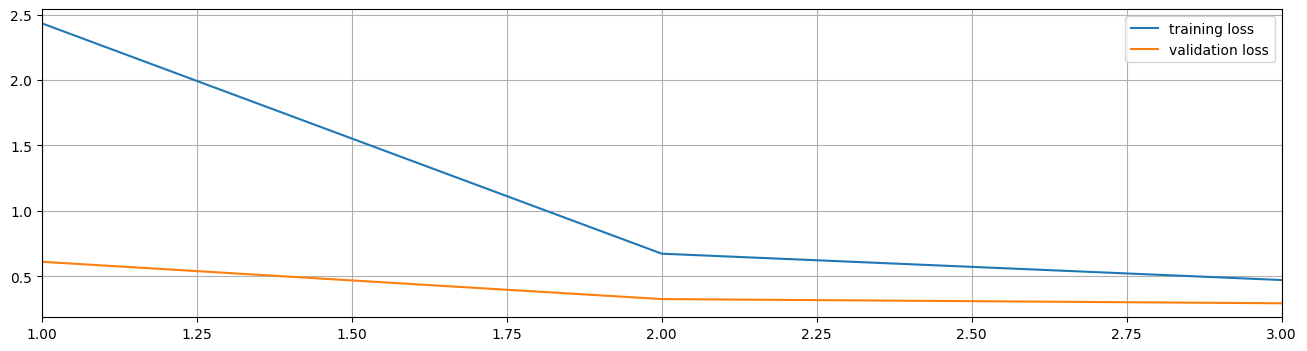

In [ ]:
%%time
bs = 32
num_of_classes = len(i2c)

tr_dl  = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
val_dl = DataLoader(test_ds, batch_size=2*bs, shuffle=False, num_workers=2)

resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, num_of_classes)
freeze_to(resnet18, -1, True)

resnet18 = resnet18.cuda()

fit(resnet18, tr_dl, val_dl, epochs=3)

# Model by Noman

In [ ]:
resnet50 = models.resnet50(pretrained=True)
resnet50

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
%%time
bs = 64
num_of_classes = len(i2c)

tr_dl  = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=3)
val_dl = DataLoader(test_ds, batch_size=2*bs, shuffle=False, num_workers=3)

resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, num_of_classes)
freeze_to(resnet50, -1, True)

resnet50 = resnet50.cuda()

fit(resnet50, tr_dl, val_dl, epochs=3)

# Model by Vishal

In [ ]:
swin_v2_t = models.swin_v2_t(pretrained=True)
swin_v2_t

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_V2_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_V2_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 0	training loss: 1.3196	validation loss: 0.3995	validation accuracy: 0.92


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 1	training loss: 0.1707	validation loss: 0.2859	validation accuracy: 0.93


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 2	training loss: 0.0987	validation loss: 0.2488	validation accuracy: 0.94


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 3	training loss: 0.0717	validation loss: 0.2254	validation accuracy: 0.94
CPU times: user 2min 38s, sys: 24.6 s, total: 3min 3s
Wall time: 37min 20s


([1.3195939, 0.17065899, 0.09871488, 0.07173236],
 [0.39947495, 0.2859151, 0.24879573, 0.22541034])

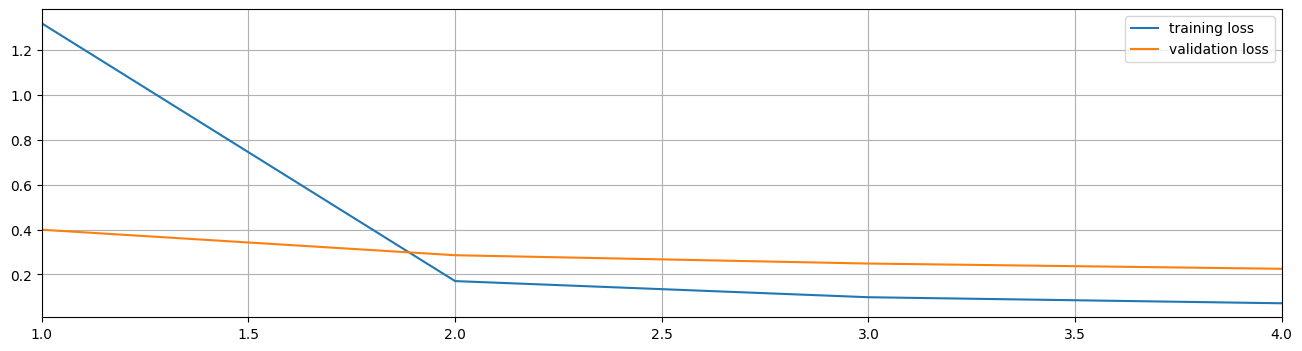

In [ ]:
%%time
bs = 32
num_of_classes = len(i2c)

tr_dl  = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
val_dl = DataLoader(test_ds, batch_size=2*bs, shuffle=False, num_workers=2)

swin_v2_t = models.swin_v2_t(pretrained=True)
swin_v2_t.head = nn.Linear(768, num_of_classes)
freeze_to(swin_v2_t, -1, True)

swin_v2_t= swin_v2_t.cuda()

fit(swin_v2_t, tr_dl, val_dl, epochs=4)

# Model by Ayo